In [1]:
from json import load
from lib2to3.pgen2.pgen import DFAState
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler


data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

data = torch.from_numpy(df.values).float()
X = data[:, :-1]
y = data[:, -1:]

print(f'X shape : {X.shape} / y Shape : {y.shape}')

X shape : torch.Size([569, 30]) / y Shape : torch.Size([569, 1])


In [3]:
# Train / Valid / Test 데이터 분리

ratios = [.6, .3, .1]

train_cnt = int(X.size(0) * ratios[0])
valid_cnt = int(X.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print('Train Dataset %d / Valid Dataset %d / Test Dataset %d' %(cnts[0], cnts[1], cnts[2]))

Train Dataset 341 / Valid Dataset 170 / Test Dataset 58


In [4]:
indices = torch.randperm(X.size(0))

X = torch.index_select(X, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

X = X.split(cnts, dim=0)
y = y.split(cnts, dim=0)

for x_i, y_i in zip(X, y):
    print(x_i.shape, '/', y_i.shape)

torch.Size([341, 30]) / torch.Size([341, 1])
torch.Size([170, 30]) / torch.Size([170, 1])
torch.Size([58, 30]) / torch.Size([58, 1])


In [5]:
scaler = StandardScaler()

x = [torch.from_numpy(scaler.fit_transform(X[0].numpy())).float(),
    torch.from_numpy(scaler.transform(X[1].numpy())).float(),
    torch.from_numpy(scaler.transform(X[2].numpy())).float()]


In [6]:
model = nn.Sequential(
    nn.Linear(x[0].size(1), 25),
    nn.LeakyReLU(),
    nn.Linear(25, 20),
    nn.LeakyReLU(),
    nn.Linear(20, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 10),
    nn.LeakyReLU(),
    nn.Linear(10, 5),
    nn.LeakyReLU(),
    nn.Linear(5, y[0].size(-1)),
    nn.Sigmoid()
)

print(model)
optimizer = optim.Adam(model.parameters())

Sequential(
  (0): Linear(in_features=30, out_features=25, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=25, out_features=20, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=20, out_features=15, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=15, out_features=10, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=10, out_features=5, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=5, out_features=1, bias=True)
  (11): Sigmoid()
)


In [7]:
n_epochs = 10000
batch_size = 128
print_interval = 100
early_stop = 100

lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

In [8]:
train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(x[0].size(0))

    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += float(loss)

    train_loss += train_loss / len(x_)

    with torch.no_grad():
        
        x_ = x_[1].split(batch_size, dim=0)
        y_ = y_[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.binary_cross_entropy(y_hat_i, y_i)

            valid_loss += float(loss)
            y_hat += [y_hat_i]

        valid_loss = valid_loss / len(x_)

        train_history.append(train_loss)
        valid_history.append(valid_loss)


        if (i + 1) % print_interval == 0:
            print('Epoch %d: Train Loss = %.4e / Valid Loss = %.4e / Lowest Loss = %.4e' % (i+1, train_loss, valid_loss, lowest_loss))
        
        if valid_loss <= lowest_loss:
            lowest_loss = valid_loss
            lowest_epoch = i

            best_model = deepcopy(model.state_dict())
        else: 
            if early_stop > 0 and early_stop + lowest_epoch < i + 1:
                print('Early Stopping!! 훈련 종료합니다.\n마지막 Epoch=>%d: ' % (lowest_epoch+1))

                break
        
print('The best validation loss from epoch %d=> %.4e' % (lowest_epoch+1, lowest_loss))
model.load_state_dict(best_model)

Epoch 100: Train Loss = 2.9092e-02 / Valid Loss = 6.4282e-03 / Lowest Loss = 5.2549e-03
Epoch 200: Train Loss = 9.8454e-04 / Valid Loss = 3.2759e-04 / Lowest Loss = 1.0609e-04
Epoch 300: Train Loss = 3.1458e-04 / Valid Loss = 1.1567e-04 / Lowest Loss = 3.5368e-05
Epoch 400: Train Loss = 1.5794e-04 / Valid Loss = 4.0760e-05 / Lowest Loss = 2.2920e-05
Epoch 500: Train Loss = 9.4851e-05 / Valid Loss = 1.9152e-05 / Lowest Loss = 5.3707e-06
Epoch 600: Train Loss = 6.0585e-05 / Valid Loss = 9.5012e-06 / Lowest Loss = 4.2307e-06
Early Stopping!! 훈련 종료합니다.
마지막 Epoch=>511: 
The best validation loss from epoch 511=> 4.2307e-06


<All keys matched successfully>

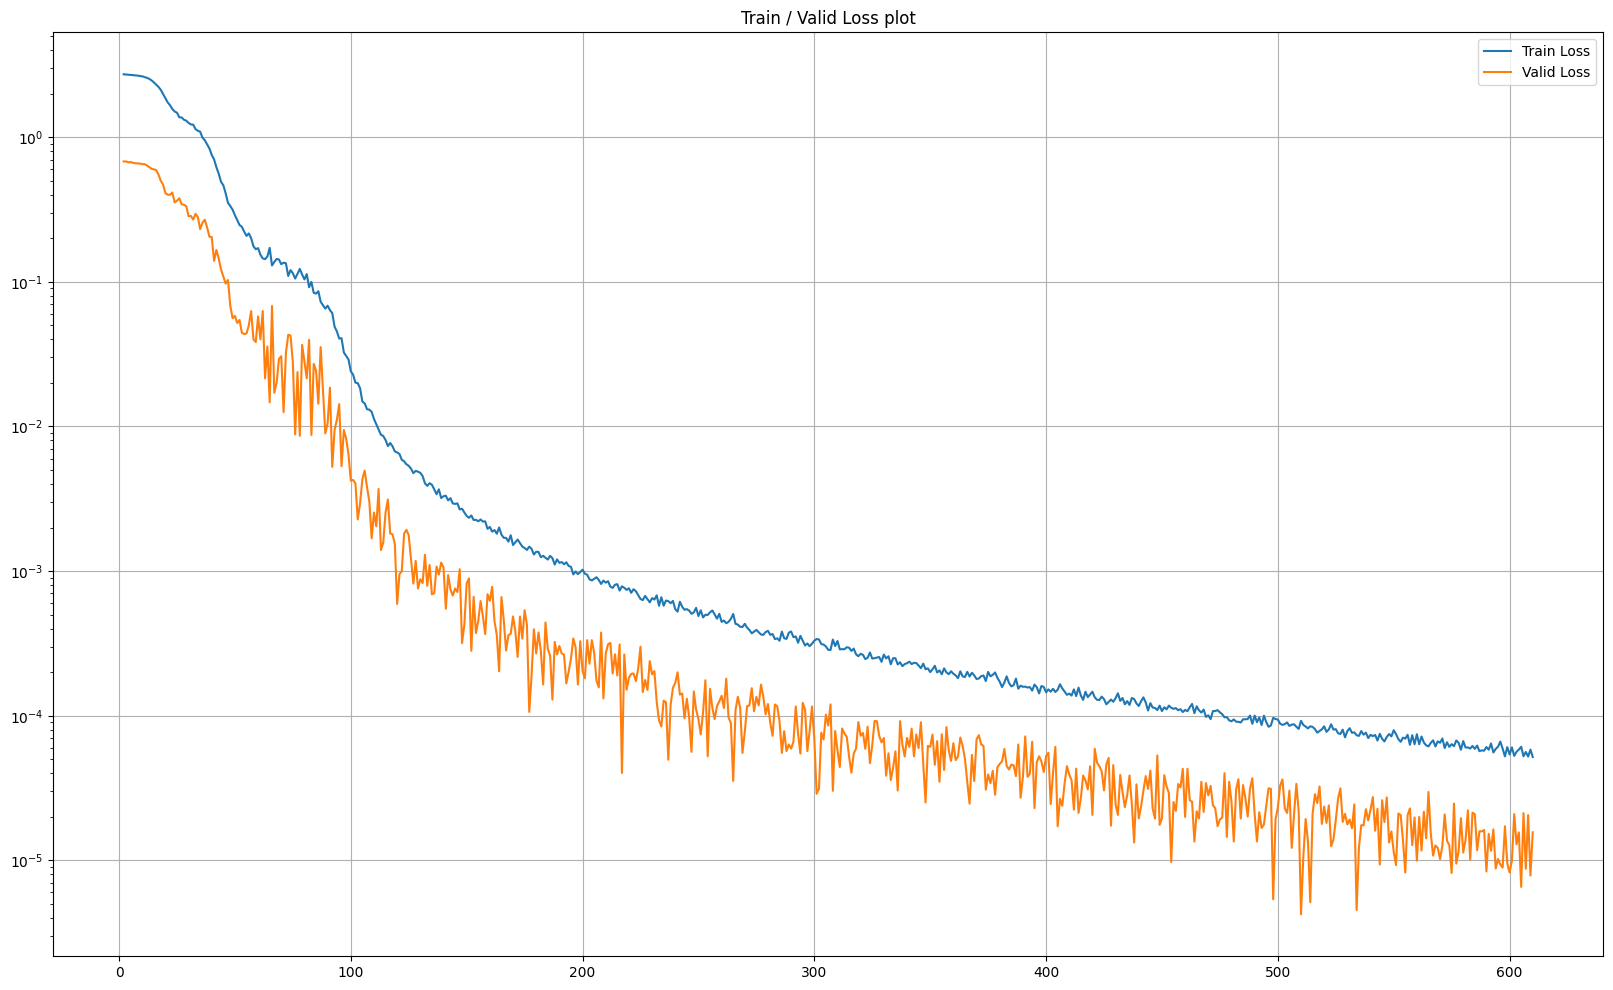

In [9]:
plot_from = 2

plt.figure(figsize=(20, 12))
plt.plot(range(plot_from, len(train_history)), train_history[plot_from:],
        range(plot_from, len(valid_history)), valid_history[plot_from:])
plt.title('Train / Valid Loss plot')
plt.grid(True)
plt.legend(['Train Loss', 'Valid Loss'])
plt.yscale('log')
plt.show()

In [10]:
test_loss = 0
y_hat = []

with torch.no_grad():

    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        test_loss += float(loss)
        y_hat += [y_hat_i]

    test_loss = test_loss / len(x_i)

y_hat = torch.cat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])


print('Train Loss: %.4e' % sorted_history[0][0])
print('Valid Loss: %.4e' % sorted_history[1][0])
print('Test Loss: %.4e' % test_loss)


Train Loss: 9.2089e-05
Valid Loss: 7.3212e-05
Test Loss: 2.9727e-02


In [11]:
y[2].size()

torch.Size([58, 1])

In [12]:
correct_cnt = (y[2] == (y_hat > .5)).sum()
total_cnt = len(y[2])

print('Test Accuracy is %.4f' % (correct_cnt / total_cnt * 100))

Test Accuracy is 98.2759


In [13]:
df = pd.DataFrame(torch.cat([y[2], y_hat], dim=1).detach().numpy(),
                columns = ['y', 'y_hat'])
df.head(10)            

,y,y_hat
0,0.0,1.000000e+00
1,1.0,1.000000e+00
2,0.0,9.622555e-09
3,1.0,1.000000e+00
4,1.0,9.999895e-01
5,0.0,7.104349e-14
6,0.0,1.853564e-13
7,1.0,1.000000e+00
8,1.0,1.000000e+00
9,1.0,1.000000e+00


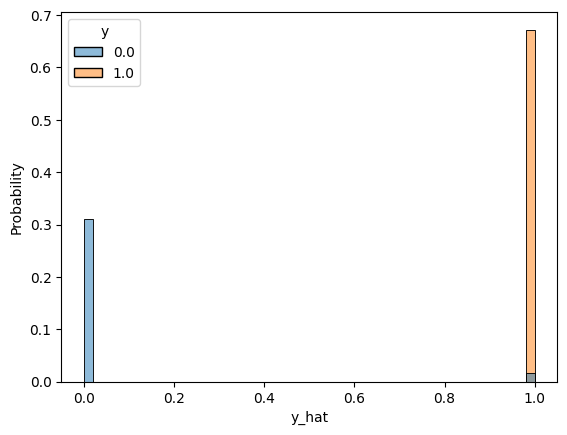

In [14]:
sns.histplot(df, x='y_hat', hue='y', bins=50, stat='probability')
plt.show()

In [15]:
from sklearn.metrics import roc_auc_score

roc_auc_score(df.values[:, 0], df.values[:, 1])

0.970310391363023

---------

## MNSIT (Deep Classification)

In [16]:
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

In [18]:
train = datasets.MNIST(
    root = '../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor()])
)

test = datasets.MNIST(
    root = '../data', train=False, download=True,
    transform=transforms.Compose(
        [transforms.ToTensor()])
)

9920512it [00:00, 14941253.61it/s]                             


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


32768it [00:00, 272431.47it/s]           


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


1654784it [00:00, 8973681.65it/s]                        


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


8192it [00:00, 76929.55it/s]            
/opt/anaconda3/envs/torch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [19]:
def plot_mnist(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28, 28)

    plt.imshow(img, cmap='gray')
    plt.show()

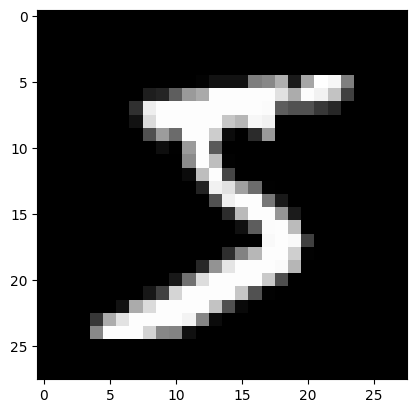

In [21]:
plot_mnist(train.data[0])

In [24]:
print(train.data.shape)
print(test.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [45]:
print("x =>", train.data[0].max(), train.data[0].min())
print("y =>", train.targets.max(), train.targets.min())

x => tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)
y => tensor(9) tensor(0)


In [55]:
x = train.data.float() / 255.
y = train.targets

x = x.view(x.size(0), -1)
print(x.shape, y.shape)

torch.Size([60000, 784]) torch.Size([60000])


In [56]:
input_size = x.size(-1)
output_size = int(max(y)) + 1 # 0~9 => 10개

print('input_size: %d, output_size: %d' %(input_size, output_size))  ## 784 => 10

input_size: 784, output_size: 10


In [57]:
test.data.shape

torch.Size([10000, 28, 28])

In [85]:
## Train / Valid / Test 데이터셋 분리

ratios = [.8, .2]
train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)

cnts = [train_cnt, valid_cnt]

print('Train Data:%d / Valid Data:%d / Test Data:%d' % (cnts[0], cnts[1], test_cnt))

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float() / 255.0).view(test_cnt, -1)]
y += [test.targets]

for x_i, y_i in zip(x, y):
    print(x_i.shape, y_i.shape)


AttributeError: 'list' object has no attribute 'size'

In [86]:
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax()  ## NLL 손실함수를 사용하기 위해서는 로그소프트맥스 함수를 모델 마지막에 사용 (SoftMax + CE == LogSoftMax + NLL(negative Log Likelihood))
)

optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss()
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=500, out_features=400, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=400, out_features=300, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=300, out_features=200, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=200, out_features=100, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=100, out_features=50, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=50, out_features=10, bias=True)
  (13): LogSoftmax(dim=None)
)


In [87]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

cpu


In [88]:
model = model.to(device)  ## device로 모델 이동.. (cuda일경우)

x = [x_i.to(device) for x_i in x] # Train [0] / Valid [1] / Test [2]
y = [y_i.to(device) for y_i in y]

In [91]:
## 필요한 하이퍼파라미터

n_epochs = 1000
batch_size = 256
print_interval = 10

lowest_loss = np.inf
lowest_epoch = np.inf

best_model = None
early_stop = 100

In [92]:
y_i[0].squeeze()

tensor(5)

In [93]:
train_history, valid_histry = [], []

for i in range(n_epochs):
    # 데이터 섞기 -> minibatch
    indices = torch.randperm(x[0].size(0)).to(device)

    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []

    # Train ~ (minibatch - x[0])
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)  # 예측
        loss = crit(y_hat_i, y_i) # Loss 계산

        optimizer.zero_grad() # gradients 초기화
        loss.backward()       # backpropagation
        optimizer.step()      # gradients 업데이트

        train_loss += float(loss)

    train_loss = train_loss / len(x_)

    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i)

            valid_loss += float(loss)
            y_hat += [y_hat_i]

    valid_loss = valid_loss / len(x_i)

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    if (i+1) % print_interval == 0:
        print('Epoch %d Train Loss : %.4e / Valid Loss : %.4e / Lowest Loss : %.4e' %(i+1, train_loss, valid_loss, lowest_loss))

    if valid_loss < lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i

        best_model = deepcopy(model.state_dict())


    if early_stop > 0 and (lowest_epoch + early_stop) < i + 1:
        print('Early Stopping!! ==> %d : (Loss) %.4e' %(lowest_epoch+1, lowest_loss))
        break

print('훈련 종료! Best Lowest Epoch:%d / Lowest Loss:%.4e' %(lowest_epoch+1, lowest_loss))
model.load_state_dict(best_model)

/opt/anaconda3/envs/torch/lib/python3.7/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 10 Train Loss : 2.3090e-02 / Valid Loss : 2.3585e-02 / Lowest Loss : 2.0011e-02
Epoch 20 Train Loss : 1.5076e-02 / Valid Loss : 2.3699e-02 / Lowest Loss : 2.0011e-02
Epoch 30 Train Loss : 9.2653e-03 / Valid Loss : 2.5682e-02 / Lowest Loss : 2.0011e-02
Epoch 40 Train Loss : 5.9529e-03 / Valid Loss : 2.6843e-02 / Lowest Loss : 2.0011e-02
Epoch 50 Train Loss : 4.1496e-03 / Valid Loss : 3.0437e-02 / Lowest Loss : 2.0011e-02
Epoch 60 Train Loss : 2.3800e-03 / Valid Loss : 2.7053e-02 / Lowest Loss : 2.0011e-02
Epoch 70 Train Loss : 2.8329e-05 / Valid Loss : 3.1585e-02 / Lowest Loss : 2.0011e-02
Epoch 80 Train Loss : 7.3203e-07 / Valid Loss : 3.7077e-02 / Lowest Loss : 2.0011e-02
Epoch 90 Train Loss : 7.8361e-08 / Valid Loss : 4.5164e-02 / Lowest Loss : 2.0011e-02
Epoch 100 Train Loss : 9.4989e-09 / Valid Loss : 5.5179e-02 / Lowest Loss : 2.0011e-02
Early Stopping!! ==> 8 : (Loss) 2.0011e-02
훈련 종료! Best Lowest Epoch:8 / Lowest Loss:2.0011e-02


<All keys matched successfully>

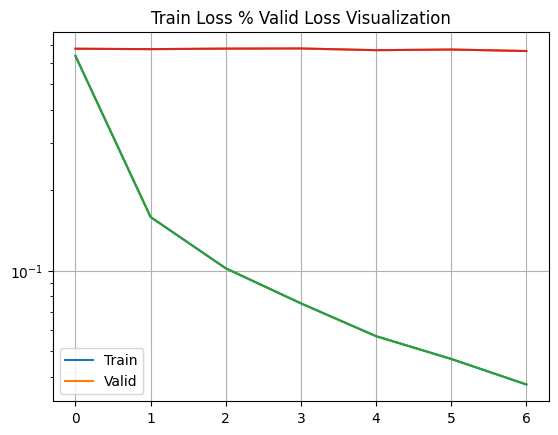

In [99]:
plot_from = 0

plt.plot(range(plot_from, lowest_epoch), train_history[plot_from:lowest_epoch],
        range(plot_from, lowest_epoch), valid_history[plot_from:lowest_epoch])
plt.legend(['Train', 'Valid'])
plt.title('Train Loss % Valid Loss Visualization')
plt.yscale('log')
plt.grid(True)
plt.show()

In [100]:
test_loss = 0 
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)

        loss = crit(y_hat_i, y_i)

        test_loss += float(loss)
        y_hat.append(y_hat_i)

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print('Test Loss : %.4e'  % (test_loss))

/opt/anaconda3/envs/torch/lib/python3.7/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test Loss : 8.2406e-02


In [108]:
y_hat_i[1]  ## 10개 Class에 대한 확률값 => 1개로 해줘야해

tensor([-1.4898e+01, -8.5052e+00, -2.3684e-04, -1.1025e+01, -1.6170e+01,
        -1.6900e+01, -1.7236e+01, -1.1530e+01, -1.1766e+01, -1.9504e+01])

In [109]:
y_hat_i.shape

torch.Size([16, 10])

In [110]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print('Test Accuracy: %.4f' % (correct_cnt / total_cnt))


Test Accuracy: 0.9775


In [143]:
y[2]

tensor([7, 2, 1,  ..., 4, 5, 6])

In [144]:
y_2 = torch.argmax(y_hat, dim=-1)

In [151]:
pd.DataFrame(np.stack([y[2], y_2], axis=1), columns=['y', 'y_hat']).head()

,y,y_hat
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4


In [153]:
from sklearn.metrics import classification_report

print(classification_report(y[2], y_2))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.97      0.97       892
           6       0.99      0.97      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

